# Behavioral Profile Stratification via Unsupervised learning

### TODO

> Please report some description here about the pipeline and what I am going to find in the notebook

## Step 1: Data Loading

> Short description here - and notes on Data Accessibility

In [1]:
from dataset import access_db, data_wrangling, cohort_info

In [2]:
# it returns a dictionary of pandas dataframes storing tables from the db
tables = access_db()

In [3]:
# reduced dictionary (it excludes tables and subjects taht are not required, e.g., ados-2modulo4, eas)
rid_tables = data_wrangling(tables)

In [4]:
# it returns dictionary of subjects info and encounters
pinfo, penc = cohort_info(rid_tables)

## Step 2: Feature Processing

> Short description here

In [5]:
from features import DataFeatures

In [6]:
datafeatures = DataFeatures(level=4, df_dict=rid_tables)

In [7]:
behr, (bt_to_idx, idx_to_bt) = datafeatures.create_level_tokens()

In [8]:
feat_df, feat_df_scaled = datafeatures.create_level_features()

---

## Step 3: Embeddings

> Short description here

In [9]:
from pt_embedding import Pembeddings

In [10]:
model = Pembeddings(behr, bt_to_idx)

In [11]:
svd_pid_list, svd_mtx = model.tfidf()

Performing SVD on the TF-IDF matrix...


In [12]:
glove_pid_list, glove_emb, word_emb = model.glove_pemb()


Training Glove embeddings...
epoch 0, error 0.016
epoch 10, error 0.013
epoch 20, error 0.011
epoch 30, error 0.010
epoch 40, error 0.010


In [13]:
w2v_pid_list, w2v_emb, w2v_word_emb, _ = model.word2vec_emb()

Loss at epoch 0: 9.477146940279944
Loss at epoch 10: 6.3844455346059945
Loss at epoch 20: 5.787768892435149
Loss at epoch 30: 5.534557239130544
Loss at epoch 40: 5.425090117243841


---

## Step 4: Clustering

> Short description here

In [13]:
from clustering import HclustEmbeddings, HclustFeatures
import utils as ut

In [14]:
hclust_emb = HclustEmbeddings(min_cl=ut.min_cl, max_cl=ut.max_cl, 
                              affinity='euclidean', linkage='ward')

### `TF-IDF` Embedding

In [52]:
# TFIDF EMBEDDING
# tfidf_best_cl = hclust_emb.find_best_nclu(svd_mtx, n_iter=ut.n_iter, 
#                                           subsampl=ut.subsampl)
tfidf_best_cl = hclust_emb.elbow_method(svd_mtx)

In [53]:
tfidf_subc = hclust_emb.fit(svd_mtx, svd_pid_list, tfidf_best_cl)

(*) Number of clusters 2 -- Silhouette score 0.38
Cluster 0 -- Numerosity 97
Cluster 1 -- Numerosity 108






### `Glove` Embedding

In [15]:
# GLOVE EMBEDDING
# glv_best_cl = hclust_emb.find_best_nclu(glove_emb, n_iter=ut.n_iter, subsampl=ut.subsampl)
glv_best_cl = hclust_emb.elbow_method(glove_emb)

In [16]:
glv_subc = hclust_emb.fit(glove_emb, glove_pid_list, glv_best_cl)

(*) Number of clusters 2 -- Silhouette score 0.35
Cluster 0 -- Numerosity 28
Cluster 1 -- Numerosity 177






In [45]:
km_gl_subc = KMeans(n_clusters=5).fit_predict(glove_emb)

### `Word2Vec` Embedding

In [20]:
w2v_best_cl = hclust_emb.elbow_method(w2v_emb)
w2v_subc = hclust_emb.fit(w2v_emb, w2v_pid_list, w2v_best_cl)

(*) Number of clusters 3 -- Silhouette score 0.11
Cluster 0 -- Numerosity 96
Cluster 1 -- Numerosity 95
Cluster 2 -- Numerosity 14






### Clustering and Feature Representation

> Short description here

In [21]:
hclust_feat = HclustFeatures(min_cl=ut.min_cl, max_cl=ut.max_cl, 
                             affinity='euclidean', linkage='ward')

In [22]:
# FEATURES REPRESENTATION
# feat_best_cl = hclust_feat.find_best_nclu(feat_df_scaled, n_iter=ut.n_iter, subsampl=ut.subsampl)
feat_best_cl = hclust_feat.elbow_method(feat_df_scaled)

In [23]:
feat_subc = hclust_feat.fit(feat_df_scaled, feat_best_cl)

(*) Number of clusters 2 -- Silhouette score 0.67
Cluster 0 -- Numerosity 204
Cluster 1 -- Numerosity 1






## Step 5: Clustering II (Visualization) 

> Short description here

In [18]:
from visualization import Visualization

In [19]:
viz = Visualization(pinfo, ut.col_dict, ut.c_out)

### Tf-idf 

In [26]:
# Example of visualization for tfidf embeddings
# Prepare data for umap and dendrogram
umap_mtx, pid_subc_list = viz.data_scatter_dendrogram(svd_mtx, tfidf_subc, svd_pid_list, random_state=42,
                                                      n_neighbors = 100,
                                                      min_dist=0.0)

Loading BokehJS ...

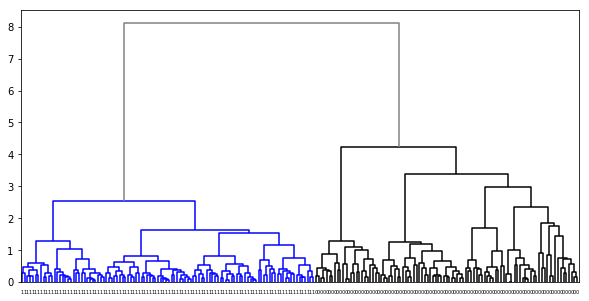

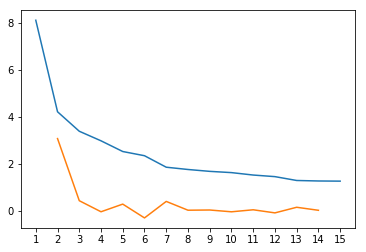

In [27]:
viz.scatterplot_dendrogram(svd_mtx, umap_mtx, pid_subc_list, 10, 5)

In [28]:
# Prepare data for heatmap
emb_scaled = viz.data_heatmap_emb(behr, bt_to_idx, tfidf_subc, 
                                  save_df='df_tfidfemb_level4.csv')

In [29]:
viz.heatmap_emb(emb_scaled, 400, 1000)

### `GloVe`

In [20]:
# Example of visualization for GloVe embeddings
# Prepare data for umap and dendrogram
umap_mtx, pid_subc_list = viz.data_scatter_dendrogram(glove_emb, glv_subc, glove_pid_list, random_state=42,
                                                      n_neighbors = 100,
                                                      min_dist=0.0)

Loading BokehJS ...

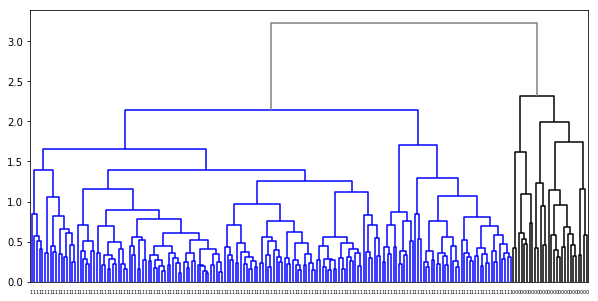

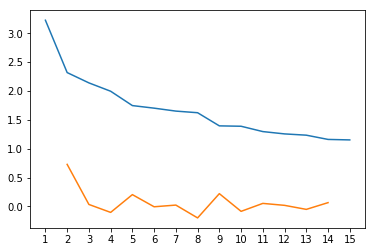

In [21]:
viz.scatterplot_dendrogram(glove_emb, umap_mtx, pid_subc_list, 10, 5)

In [49]:
ump, pdilist = viz.data_scatter_dendrogram(glove_emb, km_gl_subc, 
                            glove_pid_list, 
                            random_state=42, 
                            n_neighbors=100, min_dist=0.0)

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

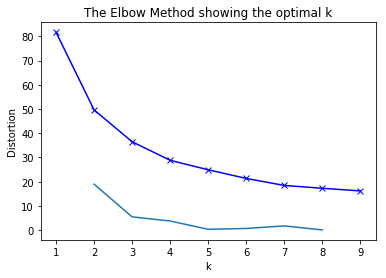

In [79]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial.distance import cdist

X = np.array(svd_mtx)
distortions = []
inertia = []
K = range(1, 10)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(X)
    distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0])
    inertia.append(kmeanModel.inertia_)
    
acceleration = np.diff(inertia, 2)
acceleration_rev = acceleration

# Plot the elbow
# plt.plot(K, distortions, 'bx-')
plt.plot(K, inertia, 'bx-')
plt.plot([k +1 for k in K[:-2]], acceleration_rev)
plt.xlabel('k')
plt.xticks(range(1,10))
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [76]:
inertia

[81.73770512034899,
 49.63892164841303,
 36.501680438731064,
 28.82896862855471,
 24.91781400504823,
 21.341318531417258,
 18.44559244287136,
 17.269821340018623,
 16.447762626735578]

In [77]:
in1 = np.diff(inertia)
in1

array([-32.09878347, -13.13724121,  -7.67271181,  -3.91115462,
        -3.57649547,  -2.89572609,  -1.1757711 ,  -0.82205871])

In [78]:
in2 = np.diff(in1)
in2

array([18.96154226,  5.4645294 ,  3.76155719,  0.33465915,  0.68076939,
        1.71995499,  0.35371239])

In [22]:
# Plot UMAP projection of word embeddings via GloVe
viz.plot_word_embedding(word_emb, idx_to_bt, 800, 
                        800,
                        n_neighbors = 20,
                        min_dist=0.0)

In [23]:
# Prepare data for heatmap
emb_scaled = viz.data_heatmap_emb(behr, bt_to_idx, glv_subc, 
                                  save_df='df_golveemb_level4.csv')

In [24]:
viz.heatmap_emb(emb_scaled, 800, 800)

### `Word2vec`

Loading BokehJS ...

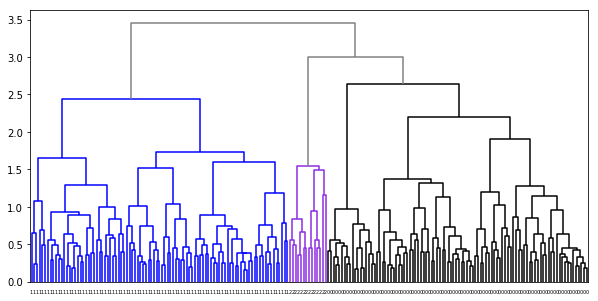

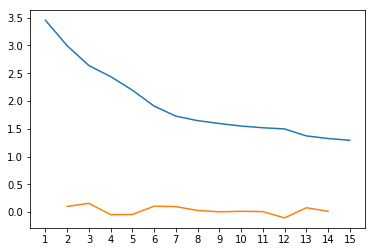

In [48]:
# Scatterplot and dendrogram of UMAP projections
umap_mtx, pid_subc_list = viz.data_scatter_dendrogram(w2v_emb, w2v_subc, w2v_pid_list, random_state=42,
                                                      n_neighbors = 10,
                                                      min_dist=0.0)
viz.scatterplot_dendrogram(w2v_emb, umap_mtx, pid_subc_list, 10, 5)

In [45]:
# Plot UMAP projection of word embeddings via Word2Vec
viz.plot_word_embedding(w2v_word_emb.transpose(), 
                        idx_to_bt, 
                        800, 
                        800,
                        n_neighbors = 20,
                        min_dist=0.0)

In [37]:
# Prepare data for heatmap
emb_scaled = viz.data_heatmap_emb(behr, bt_to_idx, w2v_subc, 
                                  save_df='df_w2vemb_level4.csv')
viz.heatmap_emb(emb_scaled, 500, 1000)

### Features

In [38]:
# Feature data visualization
# Prepare data for umap and dendrogram
umap_mtx, pid_subc_list = viz.data_scatter_dendrogram(feat_df_scaled, feat_subc, random_state=42,
                                                      n_neighbors = 100,
                                                      min_dist=0.0)

Loading BokehJS ...

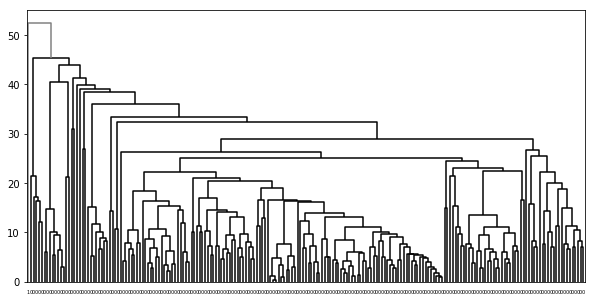

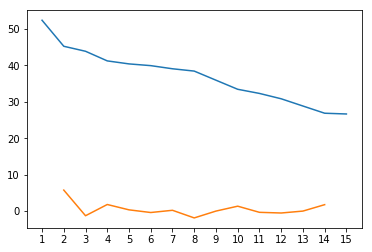

In [39]:
viz.scatterplot_dendrogram(feat_df_scaled, umap_mtx, pid_subc_list, 10, 5)

In [40]:
# Prepare data for heatmap
emb_scaled = viz.data_heatmap_feat(feat_df, feat_df_scaled, feat_subc, 
                                  save_df='df_feat_level4.csv')

In [41]:
viz.heatmap_emb(emb_scaled, 800, 1000)

---
